In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
import spacy
import re
from collections import Counter
import warnings
import json
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Custom color palettes
CUSTOM_PALETTE1 = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEEAD']
CUSTOM_PALETTE2 = ['#FFB6B9', '#FAE3D9', '#BBDED6', '#61C0BF', '#AAB7B8']

class QualityAnalyzer:
    def __init__(self, data_path):
        self.df = pd.read_csv(data_path)
        self.set_visualization_style()
        
    def set_visualization_style(self):
        sns.set_style("whitegrid", {'grid.color': '.9', 'grid.linestyle': '--'})
        plt.rcParams.update({'font.size': 12})
        plt.rcParams['axes.labelsize'] = 12
        plt.rcParams['axes.titlesize'] = 14
        
    def clean_data(self):
        # Clean dates
        date_columns = ['Opened date', 'BUILD_DATE', 'IN_USE_DATE']
        for col in date_columns:
            self.df[col] = pd.to_datetime(self.df[col], errors='coerce')
            
        # Handle missing values
        numeric_cols = self.df.select_dtypes(include=['int64', 'float64']).columns
        categorical_cols = self.df.select_dtypes(include=['object']).columns
        
        for col in numeric_cols:
            self.df[col] = self.df[col].fillna(self.df[col].median())
        for col in categorical_cols:
            self.df[col] = self.df[col].fillna(self.df[col].mode()[0])
            
        return self.get_data_overview()
    
    def get_data_overview(self):
        overview = {
            "shape": self.df.shape,
            "dtypes": self.df.dtypes,
            "missing": self.df.isnull().sum(),
            "duplicates": self.df.duplicated().sum()
        }
        return overview
    
    def create_basic_visualizations(self):
        # 1. Model Distribution
        plt.figure(figsize=(15, 6))
        model_counts = self.df['MODEL'].value_counts().head(10)
        ax = sns.barplot(x=model_counts.values, y=model_counts.index, palette=CUSTOM_PALETTE1)
        plt.title('Top 10 Models with Quality Issues', pad=20, fontweight='bold')
        plt.xlabel('Number of Issues')
        # Add value labels
        for i, v in enumerate(model_counts.values):
            ax.text(v, i, f' {v:,}', va='center')
        plt.tight_layout()
        plt.show()
        
        # 2. Manufacturing Plants Analysis
        plt.figure(figsize=(15, 6))
        plant_counts = self.df['BUILD_PLANT_DESC'].value_counts().head(10)
        plt.pie(plant_counts.values, labels=plant_counts.index, autopct='%1.1f%%', 
                colors=sns.color_palette("husl", n_colors=len(plant_counts)),
                explode=[0.05] * len(plant_counts))
        plt.title('Top Manufacturing Plants by Issue Volume', pad=20, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # 3. Complaint Categories Analysis
        plt.figure(figsize=(15, 6))
        complaint_counts = self.df['COMPLAINT_CD_DESC'].value_counts().head(10)
        ax = sns.barplot(x=complaint_counts.values, y=complaint_counts.index, 
                        palette=sns.color_palette("viridis", n_colors=len(complaint_counts)))
        plt.title('Top 10 Complaint Categories', pad=20, fontweight='bold')
        plt.xlabel('Number of Complaints')
        # Add value labels
        for i, v in enumerate(complaint_counts.values):
            ax.text(v, i, f' {v:,}', va='center')
        plt.tight_layout()
        plt.show()
        
        # 4. Causal Factors Analysis
        plt.figure(figsize=(15, 6))
        causal_counts = self.df['CAUSAL_CD_DESC'].value_counts().head(10)
        ax = sns.barplot(x=causal_counts.values, y=causal_counts.index,
                        palette=sns.color_palette("magma", n_colors=len(causal_counts)))
        plt.title('Top 10 Causal Factors', pad=20, fontweight='bold')
        plt.xlabel('Number of Occurrences')
        # Add value labels
        for i, v in enumerate(causal_counts.values):
            ax.text(v, i, f' {v:,}', va='center')
        plt.tight_layout()
        plt.show()
        
        # 5. Time Series of Issues with Moving Average
        plt.figure(figsize=(15, 6))
        daily_issues = self.df['Opened date'].value_counts().sort_index()
        # Calculate 7-day moving average
        ma7 = daily_issues.rolling(window=7).mean()
        
        plt.plot(daily_issues.index, daily_issues.values, alpha=0.5, label='Daily Issues',
                color='#45B7D1')
        plt.plot(ma7.index, ma7.values, linewidth=2, label='7-day Moving Average',
                color='#FF6B6B')
        plt.title('Issue Trends Over Time with 7-day Moving Average', pad=20, fontweight='bold')
        plt.xlabel('Date')
        plt.ylabel('Number of Issues')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # 6. Model Year vs Issues Heatmap
        plt.figure(figsize=(15, 6))
        model_year_matrix = pd.crosstab(self.df['MODLYR'], self.df['Failure Component'])
        sns.heatmap(model_year_matrix, cmap='YlOrRd', 
                   annot=True, fmt='d', cbar_kws={'label': 'Number of Issues'})
        plt.title('Model Year vs Failure Component Heatmap', pad=20, fontweight='bold')
        plt.xlabel('Failure Component')
        plt.ylabel('Model Year')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # 7. Issue Distribution by Make
        plt.figure(figsize=(15, 6))
        make_counts = self.df['MAKE'].value_counts()
        plt.pie(make_counts.values, labels=make_counts.index, autopct='%1.1f%%',
               colors=sns.color_palette("Set3", n_colors=len(make_counts)),
               explode=[0.05] * len(make_counts))
        plt.title('Issue Distribution by Make', pad=20, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def perform_text_mining(self):
        # Process text columns
        text_columns = ['CAUSAL_VERBATIM', 'CORRECTION_VERBATIM', 'CUSTOMER_VERBATIM']
        for col in text_columns:
            self.df[f'{col}_processed'] = self.df[col].apply(self.preprocess_text)
        
        # Extract entities and categorize issues
        self.df['extracted_entities'] = self.df['CUSTOMER_VERBATIM'].apply(self.extract_entities)
        self.df['issue_category'] = self.df['CUSTOMER_VERBATIM'].apply(self.categorize_issues)
        
        # Perform topic modeling
        return self.perform_topic_modeling('CUSTOMER_VERBATIM_processed')
    
    @staticmethod
    def preprocess_text(text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        lemmatizer = WordNetLemmatizer()
        return ' '.join([lemmatizer.lemmatize(token) for token in tokens])
    
    @staticmethod
    def extract_entities(text):
        if pd.isna(text):
            return []
        doc = nlp(str(text))
        entities = [ent.text for ent in doc.ents]
        entities.extend([chunk.text for chunk in doc.noun_chunks])
        return list(set(entities))
    
    @staticmethod
    def categorize_issues(text):
        if pd.isna(text):
            return "Unknown"
        text = str(text).lower()
        categories = {
            'electrical': ['electrical', 'battery', 'wire', 'circuit', 'power'],
            'mechanical': ['mechanical', 'engine', 'transmission', 'brake', 'gear'],
            'structural': ['body', 'frame', 'panel', 'door', 'window'],
            'software': ['software', 'system', 'computer', 'sensor', 'control'],
            'safety': ['safety', 'airbag', 'belt', 'crash', 'protection']
        }
        for category, keywords in categories.items():
            if any(keyword in text for keyword in keywords):
                return category
        return "Other"
    
    def perform_topic_modeling(self, text_column, n_topics=5):
        vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
        dtm = vectorizer.fit_transform(self.df[text_column].fillna(''))
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda_output = lda.fit_transform(dtm)
        
        topics = []
        feature_names = vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
            topics.append(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
        
        return topics
    
    def generate_insights(self):
        insights = {
            "issue_categories": self.df['issue_category'].value_counts().to_dict(),
            "top_failure_components": self.df['Failure Component'].value_counts().head().to_dict(),
            "model_year_distribution": self.df['MODLYR'].value_counts().sort_index().to_dict()
        }
        return insights
    
    def save_processed_data(self, output_path='processed_data.csv'):
        self.df.to_csv(output_path, index=False)

    def detailed_statistical_analysis(self):
    # Add this method to your QualityAnalyzer class
        stats = {
            'numerical_summary': self.df.describe(),
            'categorical_summary': {
                col: {
                    'unique_values': self.df[col].nunique(),
                    'top_values': self.df[col].value_counts().head(5).to_dict()
                }
                for col in self.df.select_dtypes(include=['object']).columns
            },
            'temporal_analysis': {
                'time_range': (self.df['Opened date'].min(), self.df['Opened date'].max()),
                'avg_issues_per_month': self.df.groupby(self.df['Opened date'].dt.to_period('M')).size().mean()
            }
        }
        return stats

    def enhanced_text_mining(self):
        
        # Custom entity patterns for automotive domain
        automotive_patterns = [
            {'label': 'COMPONENT', 'pattern': [{'LOWER': {'IN': ['engine', 'transmission', 'battery', 'brake']}}]},
            {'label': 'CONDITION', 'pattern': [{'LOWER': {'IN': ['failed', 'broken', 'damaged', 'malfunctioning']}}]},
            {'label': 'SYMPTOM', 'pattern': [{'LOWER': {'IN': ['noise', 'vibration', 'leak', 'error']}}]}
        ]
        
        # Add patterns to spaCy pipeline
        ruler = nlp.add_pipe("entity_ruler")
        ruler.add_patterns(automotive_patterns)
        
        def extract_automotive_entities(text):
            doc = nlp(str(text))
            entities = {
                'components': [],
                'conditions': [],
                'symptoms': []
            }
            for ent in doc.ents:
                if ent.label_ == 'COMPONENT':
                    entities['components'].append(ent.text)
                elif ent.label_ == 'CONDITION':
                    entities['conditions'].append(ent.text)
                elif ent.label_ == 'SYMPTOM':
                    entities['symptoms'].append(ent.text)
            return entities
        
        self.df['extracted_automotive_entities'] = self.df['CUSTOMER_VERBATIM'].apply(extract_automotive_entities)

    def generate_advanced_insights(self):

        def convert_to_naive(date_series):
            if pd.api.types.is_datetime64_any_dtype(date_series):
                return pd.to_datetime(date_series).dt.tz_localize(None)
            return pd.to_datetime(date_series)

        opened_date = convert_to_naive(self.df['Opened date'])
        in_use_date = convert_to_naive(self.df['IN_USE_DATE'])
        
        # Failure patterns analysis
        failure_patterns = {
            'component_failure_rates': self.df['Failure Component'].value_counts(normalize=True),
            'common_component_condition_pairs': pd.crosstab(
                self.df['Failure Component'], 
                self.df['Failure Condition']
            ),
            'time_to_failure': (
                opened_date - in_use_date
            ).describe()
        }
        
        # Root cause analysis
        root_causes = self.df.groupby(['CAUSAL_CD_DESC', 'Failure Component']).size().reset_index(name='count')
        root_causes = root_causes.sort_values('count', ascending=False)
        
        # Clustering of similar issues
        vectorizer = TfidfVectorizer(max_features=1000)
        tfidf_matrix = vectorizer.fit_transform(self.df['CUSTOMER_VERBATIM'].fillna(''))
        kmeans = KMeans(n_clusters=5, random_state=42)
        self.df['issue_cluster'] = kmeans.fit_predict(tfidf_matrix)
        
        return {
            'failure_patterns': failure_patterns,
            'top_root_causes': root_causes.head(10).to_dict(),
            'issue_clusters': self.df.groupby('issue_cluster').size().to_dict()
        }
    
    def perform_llm_analysis(self, api_key, batch_size=10):
        """
        Performs LLM-based text analysis using OpenAI API to extract detailed insights 
        from verbatim text fields.
        
        Args:
            api_key (str): OpenAI API key
            batch_size (int): Number of records to process in each batch
        
        Returns:
            dict: Structured analysis results
        """
        client = OpenAI(api_key=api_key)
        
        def analyze_text_with_gpt(text):
            if pd.isna(text) or not text.strip():
                return None
                
            system_prompt = """
            You are an automotive quality analysis expert. Analyze the following customer verbatim 
            and extract structured information in JSON format with the following fields:
            - primary_issue: Main problem described
            - components: List of affected components
            - symptoms: Observable problems
            - severity: High/Medium/Low based on safety implications
            - category: Technical category (e.g., Mechanical, Electrical, Software, etc.)
            - root_cause_hint: Possible underlying cause based on description
            - quality_impact: Impact on vehicle quality/performance
            - customer_sentiment: Positive/Negative/Neutral
            """
            
            try:
                response = client.chat.completions.create(
                    model="gpt-4-turbo-preview",  # or other appropriate model
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": f"Analyze this automotive issue: {text}"}
                    ],
                    temperature=0.3,
                    response_format={"type": "json_object"}
                )
                return json.loads(response.choices[0].message.content)
            except Exception as e:
                print(f"Error processing text: {e}")
                return None

        # Process records in batches with progress bar
        results = []
        for i in tqdm(range(0, len(self.df), batch_size), desc="Processing with GPT"):
            batch = self.df['CUSTOMER_VERBATIM'].iloc[i:i+batch_size]
            batch_results = []
            
            for text in batch:
                result = analyze_text_with_gpt(text)
                batch_results.append(result)
                time.sleep(0.5)  # Rate limiting
                
            results.extend(batch_results)
        
        # Add results to dataframe
        self.df['llm_analysis'] = results
        
        # Extract specific aspects into separate columns
        self.df['llm_primary_issue'] = self.df['llm_analysis'].apply(
            lambda x: x.get('primary_issue') if x else None
        )
        self.df['llm_severity'] = self.df['llm_analysis'].apply(
            lambda x: x.get('severity') if x else None
        )
        self.df['llm_category'] = self.df['llm_analysis'].apply(
            lambda x: x.get('category') if x else None
        )
        
        # Generate summary statistics
        analysis_summary = {
            'severity_distribution': self.df['llm_severity'].value_counts().to_dict(),
            'category_distribution': self.df['llm_category'].value_counts().to_dict(),
            'high_severity_issues': self.df[self.df['llm_severity'] == 'High']['llm_primary_issue'].tolist()
        }
        
        return analysis_summary

    def generate_llm_insights(self):
        """
        Generates business insights based on LLM analysis results.
        """
        if 'llm_analysis' not in self.df.columns:
            raise ValueError("LLM analysis has not been performed yet. Run perform_llm_analysis first.")
        
        # Aggregate insights
        insights = {
            # Critical issues by severity
            'critical_issues': self.df[self.df['llm_severity'] == 'High'].shape[0],
            
            # Most common technical categories
            'top_categories': self.df['llm_category'].value_counts().head(5).to_dict(),
            
            # Component-wise analysis
            'component_issues': self.df['llm_analysis'].apply(
                lambda x: x.get('components', []) if x else []
            ).explode().value_counts().head(10).to_dict(),
            
            # Customer sentiment analysis
            'sentiment_distribution': self.df['llm_analysis'].apply(
                lambda x: x.get('customer_sentiment') if x else None
            ).value_counts().to_dict()
        }
        
        # Generate recommendations
        recommendations = []
        
        # High severity issues
        if insights['critical_issues'] > 0:
            recommendations.append(
                f"Immediate attention required for {insights['critical_issues']} high-severity issues"
            )
        
        # Most problematic components
        top_component = max(insights['component_issues'].items(), key=lambda x: x[1])
        recommendations.append(
            f"Focus quality improvement efforts on {top_component[0]} with {top_component[1]} reported issues"
        )
        
        return {
            'insights': insights,
            'recommendations': recommendations
        }

[nltk_data] Downloading package punkt to /home/sravanth/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sravanth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sravanth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sravanth/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [18]:
print("\n=== Axion Ray Quality Analysis System ===\n")
    
# Initialize analyzer
print("Initializing analysis system...")
analyzer = QualityAnalyzer('SA Task 2 assignment.csv')


=== Axion Ray Quality Analysis System ===

Initializing analysis system...


In [19]:
# 1. Comprehensive EDA
print("\n1. EXPLORATORY DATA ANALYSIS")
print("-----------------------------")

# Data cleaning and overview
print("Performing data cleaning and initial analysis...")
overview = analyzer.clean_data()
print("\nDataset Overview:")
print(f"- Total records: {overview['shape'][0]:,}")
print(f"- Total features: {overview['shape'][1]:,}")
print(f"- Duplicate records: {overview['duplicates']:,}")


1. EXPLORATORY DATA ANALYSIS
-----------------------------
Performing data cleaning and initial analysis...

Dataset Overview:
- Total records: 1,000
- Total features: 20
- Duplicate records: 0


In [20]:
# Detailed statistical analysis
print("\nGenerating detailed statistical analysis...")
stats = analyzer.detailed_statistical_analysis()
print("\nTemporal Coverage:")
print(f"- Date range: {stats['temporal_analysis']['time_range'][0]} to {stats['temporal_analysis']['time_range'][1]}")
print(f"- Average issues per month: {stats['temporal_analysis']['avg_issues_per_month']:.2f}")



Generating detailed statistical analysis...

Temporal Coverage:
- Date range: 2019-08-27 00:00:00 to 2021-06-01 00:00:00
- Average issues per month: 43.48



Generating visualization suite...


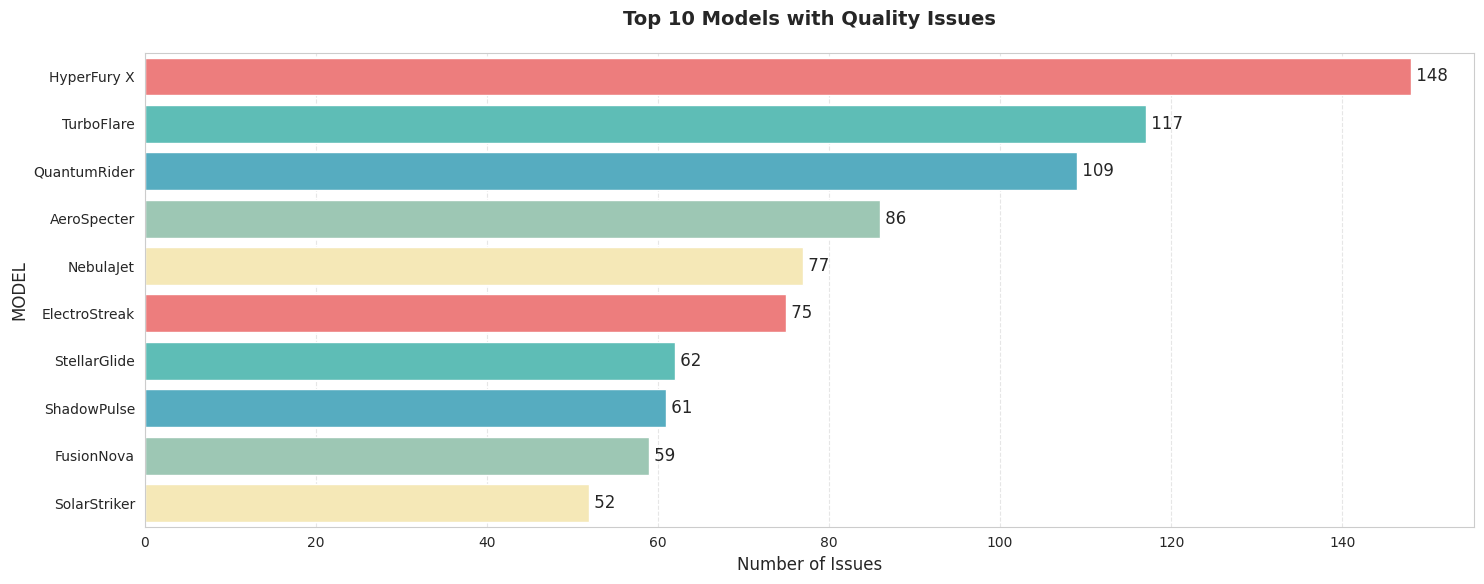

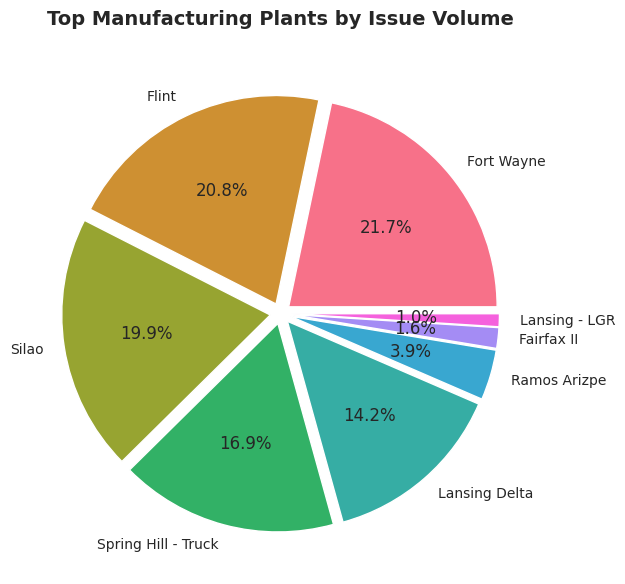

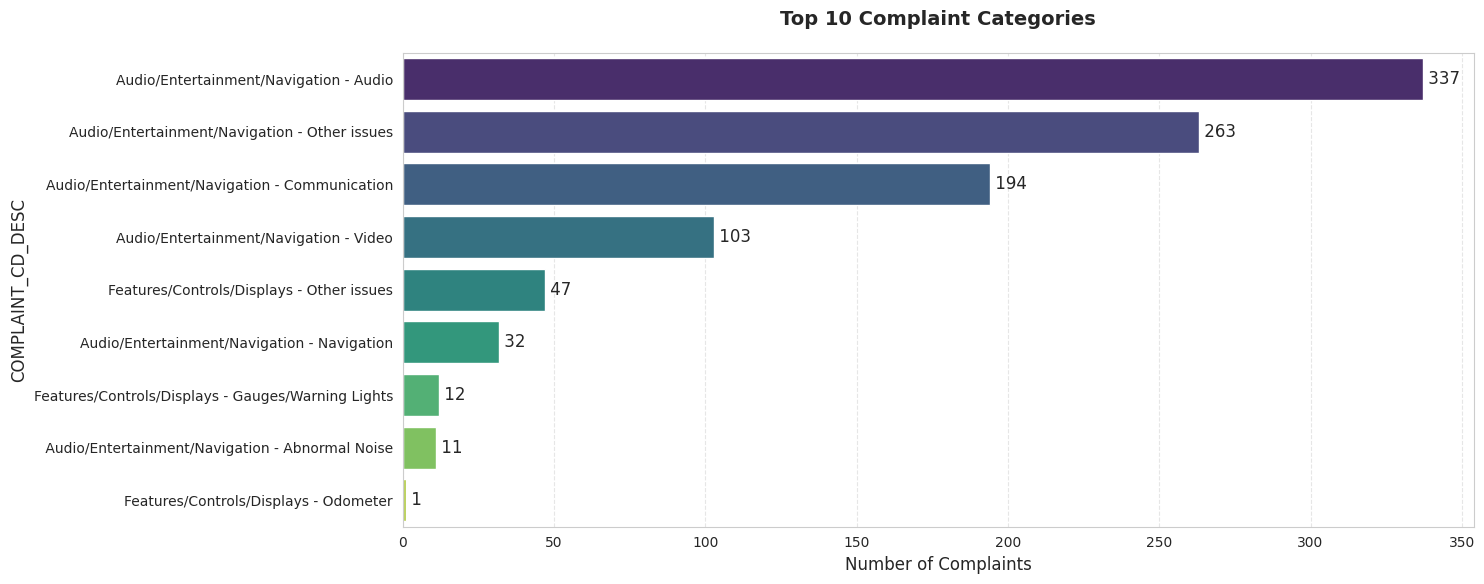

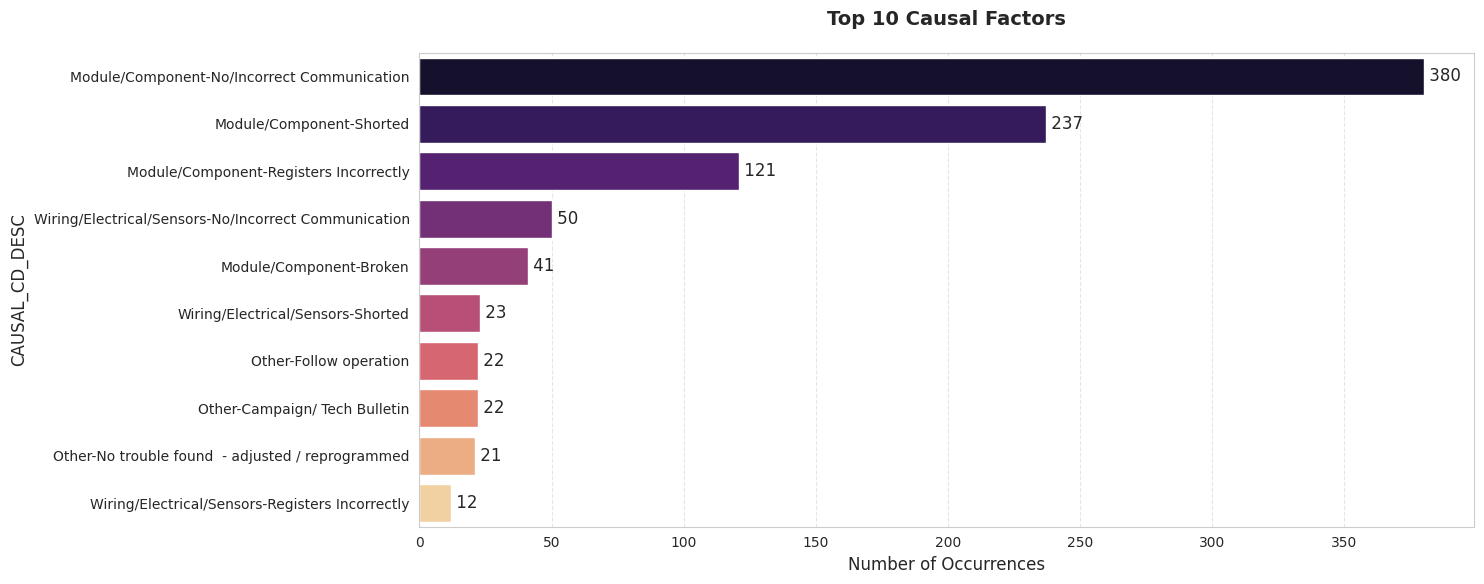

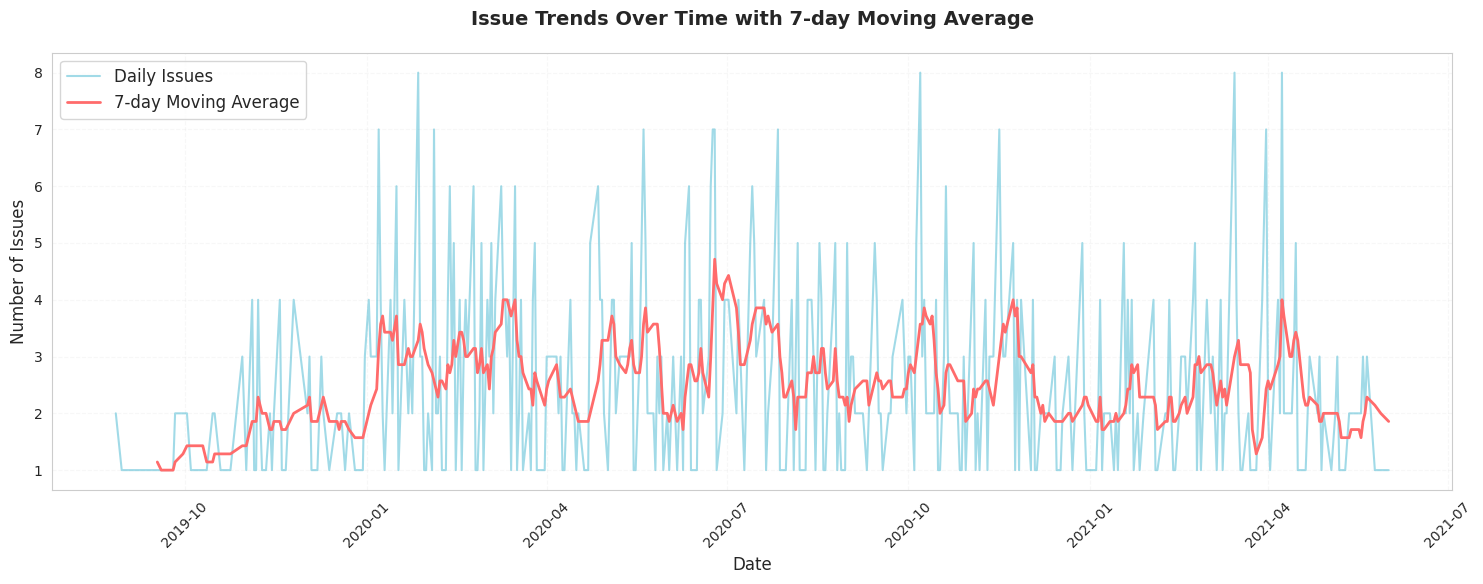

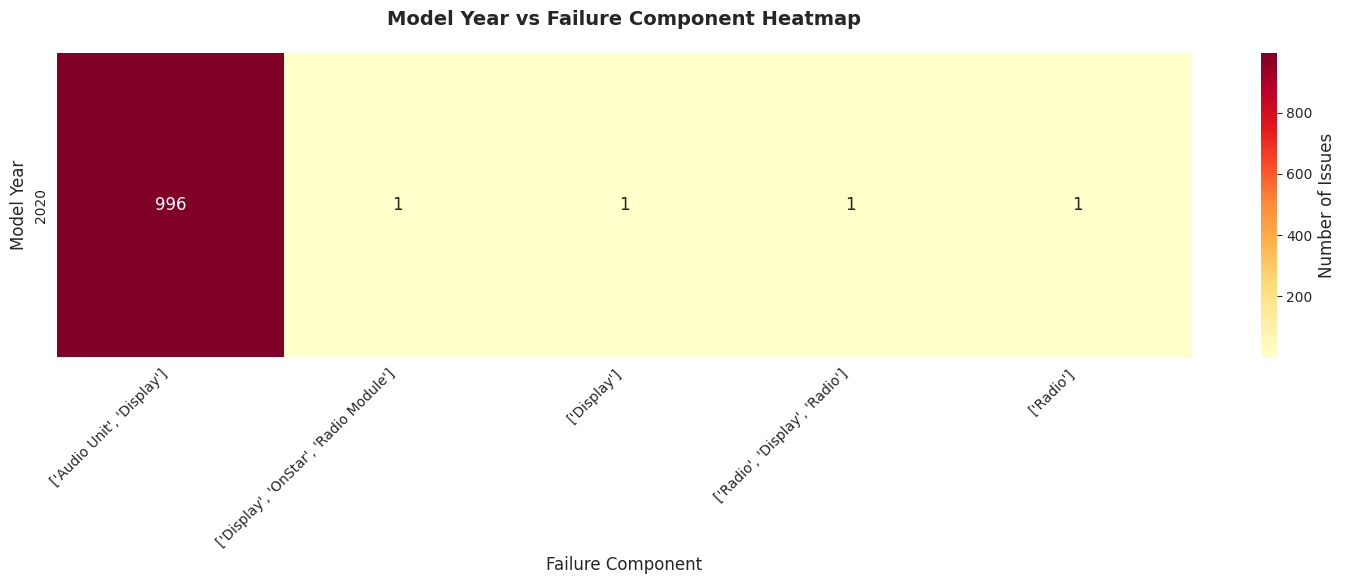

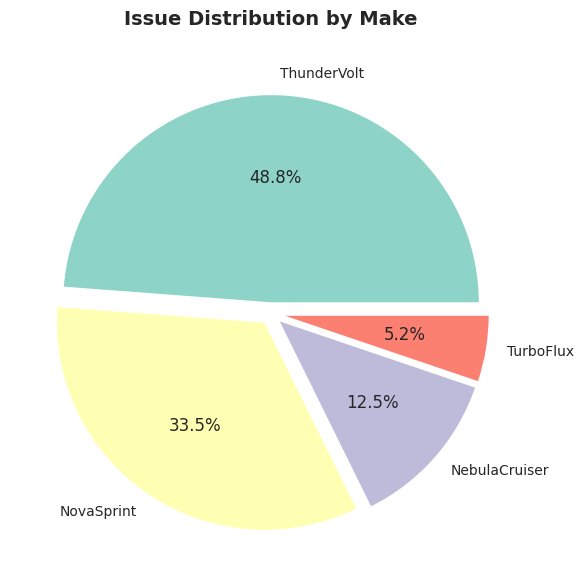

In [21]:
# Generate visualizations
print("\nGenerating visualization suite...")
analyzer.create_basic_visualizations()

In [22]:
# 2. Text Mining and NLP Analysis
print("\n2. TEXT MINING AND NLP ANALYSIS")
print("-------------------------------")

print("Performing enhanced text mining...")
# Perform enhanced entity extraction and text analysis
analyzer.enhanced_text_mining()

print("\nPerforming topic modeling...")
topics = analyzer.perform_text_mining()
print("\nIdentified Key Topics:")
for i, topic in enumerate(topics, 1):
    print(f"Topic {i}: {topic}")


2. TEXT MINING AND NLP ANALYSIS
-------------------------------
Performing enhanced text mining...

Performing topic modeling...

Identified Key Topics:
Topic 1: Topic 1: signal, xm, radio, come, work, customer, sirius, state, minute, sat
Topic 2: Topic 2: audio, radio, customer, entertainment, state, screen, issue, navigation, touch, blue
Topic 3: Topic 3: camera, working, state, customer, radio, screen, backup, inop, advise, check
Topic 4: Topic 4: phone, radio, vehicle, update, customer, state, bluetooth, went, time, work
Topic 5: Topic 5: radio, state, customer, screen, blank, inop, check, display, advise, black


In [23]:
# 3. Advanced Insights Generation
print("\n3. BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("---------------------------------------")

print("Generating comprehensive insights...")
insights = analyzer.generate_advanced_insights()

print("\nKey Failure Patterns:")
top_components = insights['failure_patterns']['component_failure_rates'].head(5)
for component, rate in top_components.items():
    print(f"- {component}: {rate*100:.1f}% of all failures")

print("\nCluster Analysis:")
for cluster, count in insights['issue_clusters'].items():
    print(f"- Cluster {cluster}: {count} issues")


3. BUSINESS INSIGHTS AND RECOMMENDATIONS
---------------------------------------
Generating comprehensive insights...

Key Failure Patterns:
- ['Audio Unit', 'Display']: 99.6% of all failures
- ['Radio', 'Display', 'Radio']: 0.1% of all failures
- ['Display', 'OnStar', 'Radio Module']: 0.1% of all failures
- ['Display']: 0.1% of all failures
- ['Radio']: 0.1% of all failures

Cluster Analysis:
- Cluster 0: 118 issues
- Cluster 1: 250 issues
- Cluster 2: 261 issues
- Cluster 3: 233 issues
- Cluster 4: 138 issues


In [25]:
# 4. Save Results
print("\n4. SAVING RESULTS")
print("----------------")

# Save processed data
analyzer.save_processed_data('processed_quality_data.csv')
print("✓ Processed data saved to 'processed_quality_data.csv'")

# save report
report = {
    'overview': overview,
    'statistics': stats,
    'insights': insights,
    'topics': topics
}

with open('quality_analysis_report.json', 'w') as f:
    json.dump(report, f, default=str, indent=4)
print("✓ Full analysis report saved to 'quality_analysis_report.json'")

print("\n=== Analysis Complete ===")


4. SAVING RESULTS
----------------
✓ Processed data saved to 'processed_quality_data.csv'
✓ Full analysis report saved to 'quality_analysis_report.json'

=== Analysis Complete ===
